# Homework 2. Social network analysis
### *Александр Анисимов, https://github.com/sanisimov98/networks_dh_2020*

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import collections
import math
import numpy as np
from networkx.relabel import relabel_nodes
from community import community_louvain
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms import community
import itertools
from networkx.algorithms.core import k_core

### Сбор и очистка данных:

In [2]:
nodes = pd.read_csv('./nodes.csv', sep = ',') #таблица узлов
edges = pd.read_csv('./edges.csv', sep = ',') #таблица рёбер

In [3]:
edges.head()

Source    Target      Type  Id  Label  timeset  Weight
0  606935  11995332  Directed   1    NaN      NaN       1
1  606935  27835117  Directed   2    NaN      NaN       1
2  606935  31918619  Directed   3    NaN      NaN       1
3  606935  48920357  Directed   4    NaN      NaN       1
4  606935  58591324  Directed   5    NaN      NaN       1

In [4]:
nodes.head()

Id               Label  timeset          0           1    2  \
0   606935       Анна Ковалова      NaN       Анна    Ковалова  NaN   
1  1687066   Герман Германович      NaN     Герман  Германович  NaN   
2  1880860  Дмитрий Шапошников      NaN    Дмитрий  Шапошников  NaN   
3  1895348    Даниил Скоринкин      NaN     Даниил   Скоринкин  NaN   
4  3962774    Екатерина Лымарь      NaN  Екатерина      Лымарь  NaN   

                   3  4                                                  5  \
0           id606935  1  https://sun1-16.userapi.com/impf/c841321/v8413...   
1  germangermanovich  2  https://sun1-85.userapi.com/impg/_8h3cY4LZZyJi...   
2          dmitriysh  2  https://sun1-25.userapi.com/impf/c853428/v8534...   
3          id1895348  2  https://sun1-93.userapi.com/impg/6f3l6-MGO61hY...   
4         lymar_kate  1  https://sun1-47.userapi.com/impf/7_oi1f9HUqxbu...   

     6   7   8          9  10  
0  0.0 NaN NaN   5.6.2006 NaN  
1  0.0 NaN NaN  17.3.1990 NaN  
2  0.0 NaN NaN        3.1 NaN  
3  0.0 NaN NaN        NaN NaN  
4  NaN NaN NaN        5.5 NaN

In [5]:
labels_and_ids = {}
for i, node in enumerate(nodes['Id']):
    labels_and_ids[node] = nodes['Label'][i]

In [6]:
# чтобы не было удалённых аккаунтов
to_delete = []
for key, value in labels_and_ids.items():
    if value == 'DELETED ':
        print(key)
        to_delete.append(key)
        
for item in to_delete:
    del labels_and_ids[item]

10038725
29318531
30637530
53015795
138296578
143018151
208742453
269660736


In [7]:
G = nx.Graph() ##использую неориентированный граф: если люди друзья, то очевидно, что связь будет двусторонней

In [8]:
for i, node in enumerate(edges['Source']):
    if node not in to_delete:
        if edges['Target'][i] not in to_delete:
            target = edges['Target'][i]
            G.add_edge(node, target)

In [9]:
G = nx.relabel_nodes(G, labels_and_ids) #чтобы отображались не id, а имена

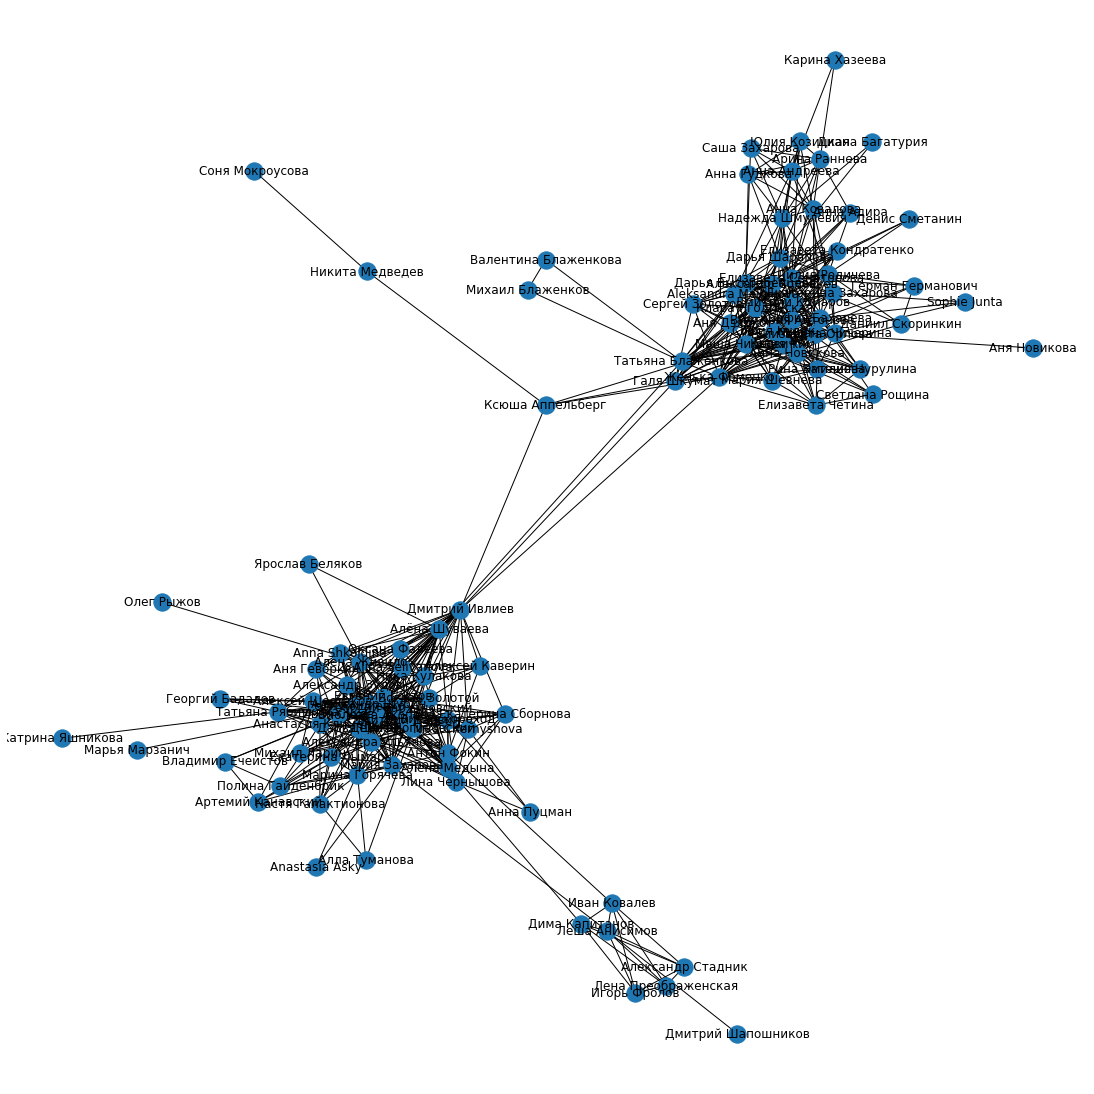

In [10]:
#общий ориентированный граф со spring_layout
pos = nx.spring_layout(G)
plt.figure(figsize=(15, 15))
nx.draw(G, pos, with_labels=True)

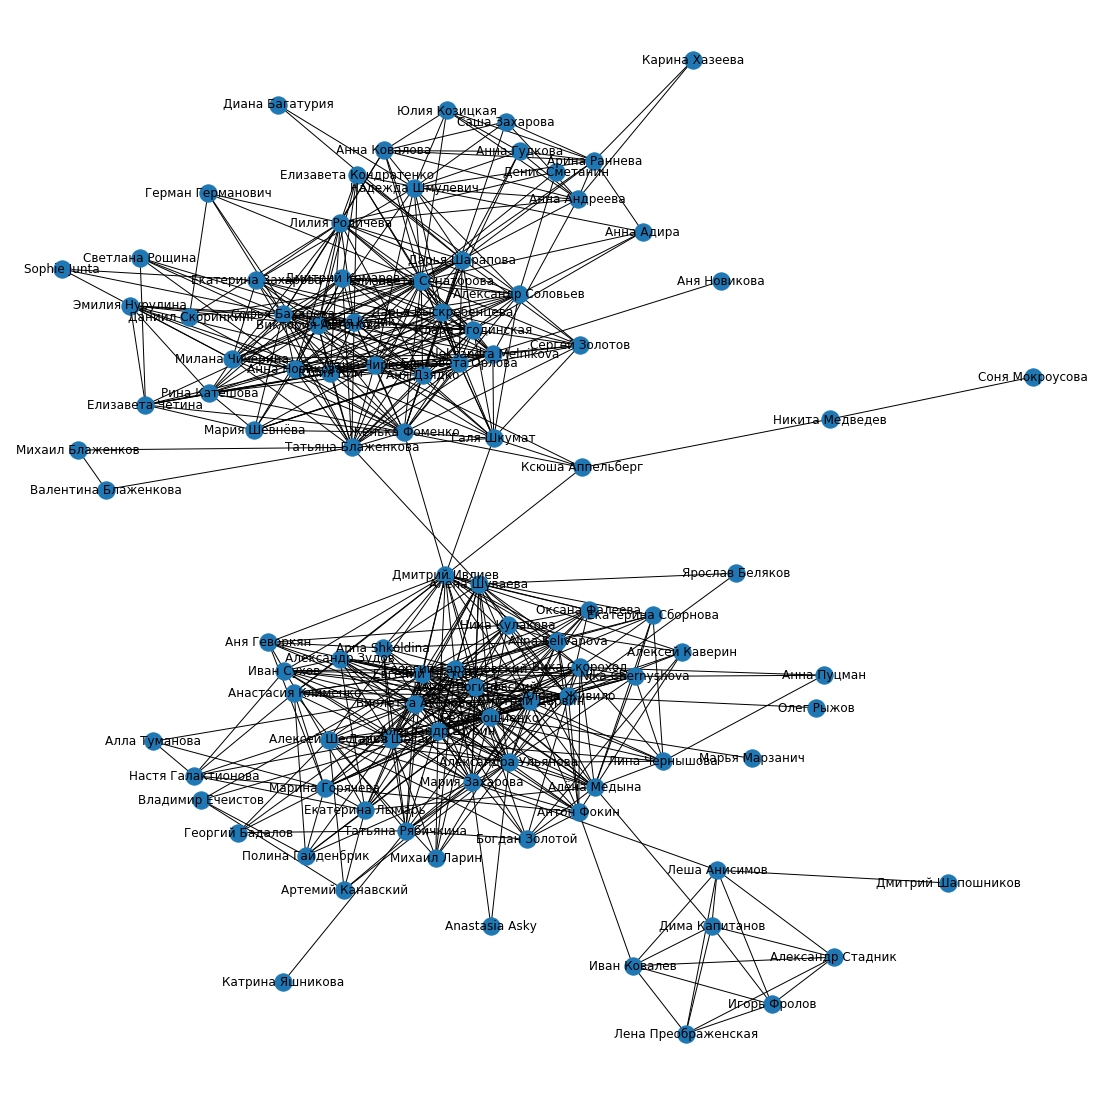

In [11]:
#общий ориентированный граф с kamada_kawai_layout 
#(кажется, читается чуть проще, так что дальше буду использовать такой вариант укладки)
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(15, 15))
nx.draw(G, pos, with_labels=True)

Сразу заметно, что в графе можно выделить 2 больших и не слишком связанных сообщества (люди, с которыми я учился в школе, и люди, с которыми я учился/работал в университете). 

### Базовый анализ графа

In [12]:
def descriptive_analysis(g, isOriented = False): ##функция, в которой проводится базовый анализ графа
    if isOriented == False:
        print('Анализ неориентированного графа')
        print('Компонент: {}'.format(nx.number_connected_components(g)))# это можно использовать только с неориентированными графами
    else:
        print('Анализ ориентированного графа')
    print('Вершин: {}'.format(len(g.nodes())))
    print('Рёбер: {}'.format(len(g.edges())))
    print('Плотность: {}'.format(nx.density(g)))
    print('Диаметр графа: {}'.format(nx.algorithms.distance_measures.diameter(g)))
    print('Средняя степень вершины: {}'.format(len(g.edges())/len(g.nodes())))
    print('Средняя кратчайшая длина пути: {}'.format(nx.average_shortest_path_length(g)))
    print('Средний коэффициент кластеризации: {}'.format(nx.average_clustering(g)))
    
    

In [13]:
descriptive_analysis(G)

Анализ неориентированного графа
Компонент: 1
Вершин: 101
Рёбер: 602
Плотность: 0.1192079207920792
Диаметр графа: 7
Средняя степень вершины: 5.96039603960396
Средняя кратчайшая длина пути: 3.057821782178218
Средний коэффициент кластеризации: 0.5955746742066134


Граф достаточно плотный и у него достаточно высокий кластерный коэффициент. Если бы диаметр графа был меньше, он бы напоминал модель Small world. 

### Описательный анализ.

In [14]:
chosen_figsize = (10, 7) #установленный размер графиков

def DegSeq_and_DegCount(g): 
    degree_sequence = sorted([d for n, d in g.degree()], reverse=True)
    degree_count = collections.Counter(degree_sequence)
    return degree_count, degree_sequence

def hist_of_degree_distr(g): 
    degree_count, degree_sequence = DegSeq_and_DegCount(g)
    deg, cnt = zip(*degree_count.items())
    plt.figure(figsize=chosen_figsize)
    plt.bar(deg, cnt, width=0.8)
    plt.title('Degree Histogram')
    plt.ylabel('Count')
    plt.xlabel('Degree')
    plt.show()

def loglog_scale(g):
    degree_count, degree_sequence = DegSeq_and_DegCount(g)
    plt.figure(figsize=chosen_figsize)
    plt.title('Log-log of degree distribution')
    plt.scatter([math.log(i) for i in degree_count.keys()], [math.log(i) for i in degree_count.values()])
    plt.show()

def loglog_and_lin_regression(g):
    degree_count, degree_sequence = DegSeq_and_DegCount(g)
    plt.figure(figsize=chosen_figsize)
    x = np.array([math.log(i) for i in degree_count.keys()])
    y = np.array([math.log(i) for i in degree_count.values()])
    m, b = np.polyfit(x, y, 1)
    plt.scatter(x, y)
    plt.plot(x, m*x + b)
    plt.title('Log-log of degree distribution with linear regression')
    plt.show()

In [15]:
hist_of_degree_distr(G) 

In [16]:
#loglog_scale(G) #эта ячейка отрисовывает degree distribution без линейной регрессии

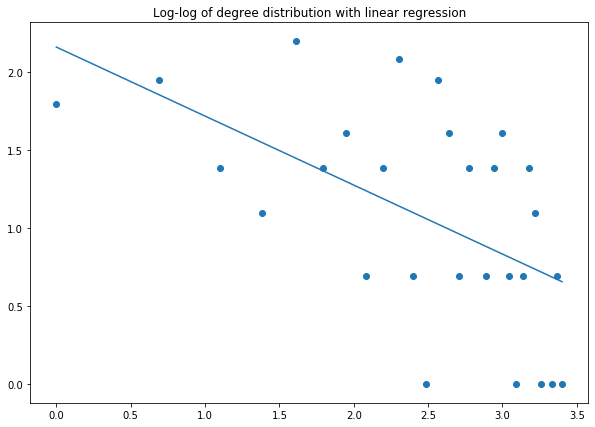

In [17]:
loglog_and_lin_regression(G)

Граф (в целом) подчиняется степенному распределению. Значит, получившийся гарф можно считать реальной социальной сетью.

### Центральности

Создам DataFrame pandas, содержащий значения центральности для каждого узла графа.

In [18]:
def centralities(g):
    centralities_df = pd.DataFrame({
        'degree_centrality' : nx.degree_centrality(g),
        'closeness_centrality' : nx.closeness_centrality(g),
        'eigenvector_centrality' : nx.eigenvector_centrality_numpy(g),
        'betweenness_centrality' : nx.betweenness_centrality(g),
    })
    return centralities_df

In [19]:
#почему-то обычный nx.eigenvector_centrality не работает, ориентируясь на stackoverflow нашёл такой 
#(https://stackoverflow.com/questions/43208737/using-networkx-to-calculate-eigenvector-centrality) вариант решения
#но без библиотеки scipy он не работает, так что
#!pip install scipy

In [20]:
centralities_df = centralities(G)

In [21]:
centralities_df.head()

degree_centrality  closeness_centrality  \
Анна Ковалова                      0.10              0.297619   
Юлия Козицкая                      0.06              0.288184   
Елизавета Сенаторова               0.29              0.387597   
Елизавета Орлова                   0.18              0.370370   
Надежда Шмулевич                   0.14              0.303951   

                      eigenvector_centrality  betweenness_centrality  
Анна Ковалова                       0.008313                0.003191  
Юлия Козицкая                       0.003956                0.000115  
Елизавета Сенаторова                0.033725                0.078010  
Елизавета Орлова                    0.026386                0.027002  
Надежда Шмулевич                    0.012379                0.008873

In [22]:
set_figsize=(25, 22) #опять же устанавливаю единый размер для следующих графиков

In [23]:
def draw_graph_with_different_nodes(g, centrality_list): ##чтобы не повторять четыре раза один и тот же код отрисовки
    pos = nx.kamada_kawai_layout(g)
    plt.figure(figsize=set_figsize)
    g_edges = nx.draw_networkx_edges(g, pos,
                                     edge_color = 'grey',
                                     alpha = 0.5,)
    g_nodes = nx.draw_networkx_nodes(g, pos, 
                                     node_size=list([i*2000 for i in centrality_list]),
                                     node_color=centrality_list,
                                     cmap=plt.cm.magma,)
    g_labels = nx.draw_networkx_labels(g, pos, alpha = 0.8,)
    plt.colorbar(g_nodes)

In [24]:
betweenness = list(centralities_df['betweenness_centrality'])
closeness = list(centralities_df['closeness_centrality'])
eigenvector = list(centralities_df['eigenvector_centrality'])
degree = list(centralities_df['degree_centrality'])

In [25]:
draw_graph_with_different_nodes(G, degree) #degree centrality

*Degree centrality*. На этом графе выделяются узлы с наибольшим количеством соседей. Интуитивно этот граф мне кажется наиболее точно отображающим реальную ситуацию.

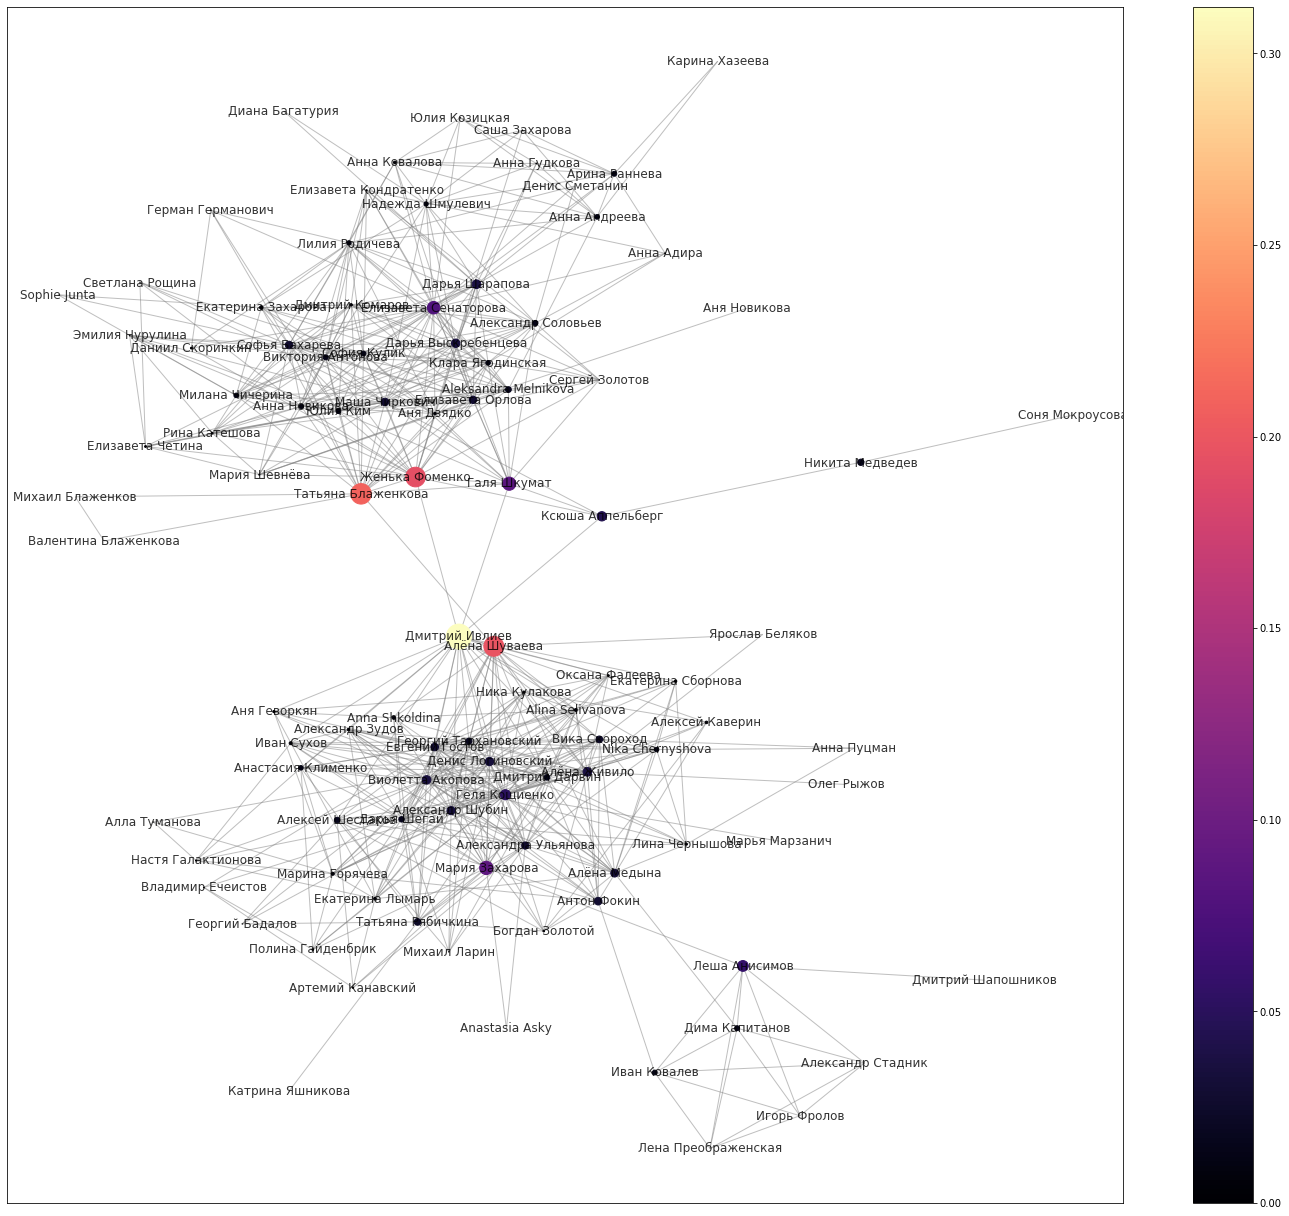

In [26]:
draw_graph_with_different_nodes(G, betweenness) #betweenness centrality

*Betweenness centrality*. На этом графе сильнее всего выделяются те точки, через которые проходит большая часть кратчайших путей между вершинами. Такой граф кажется не слишком информативным, выделяются, по сути, только те, у кого есть связи с узлами из разных частей графа.

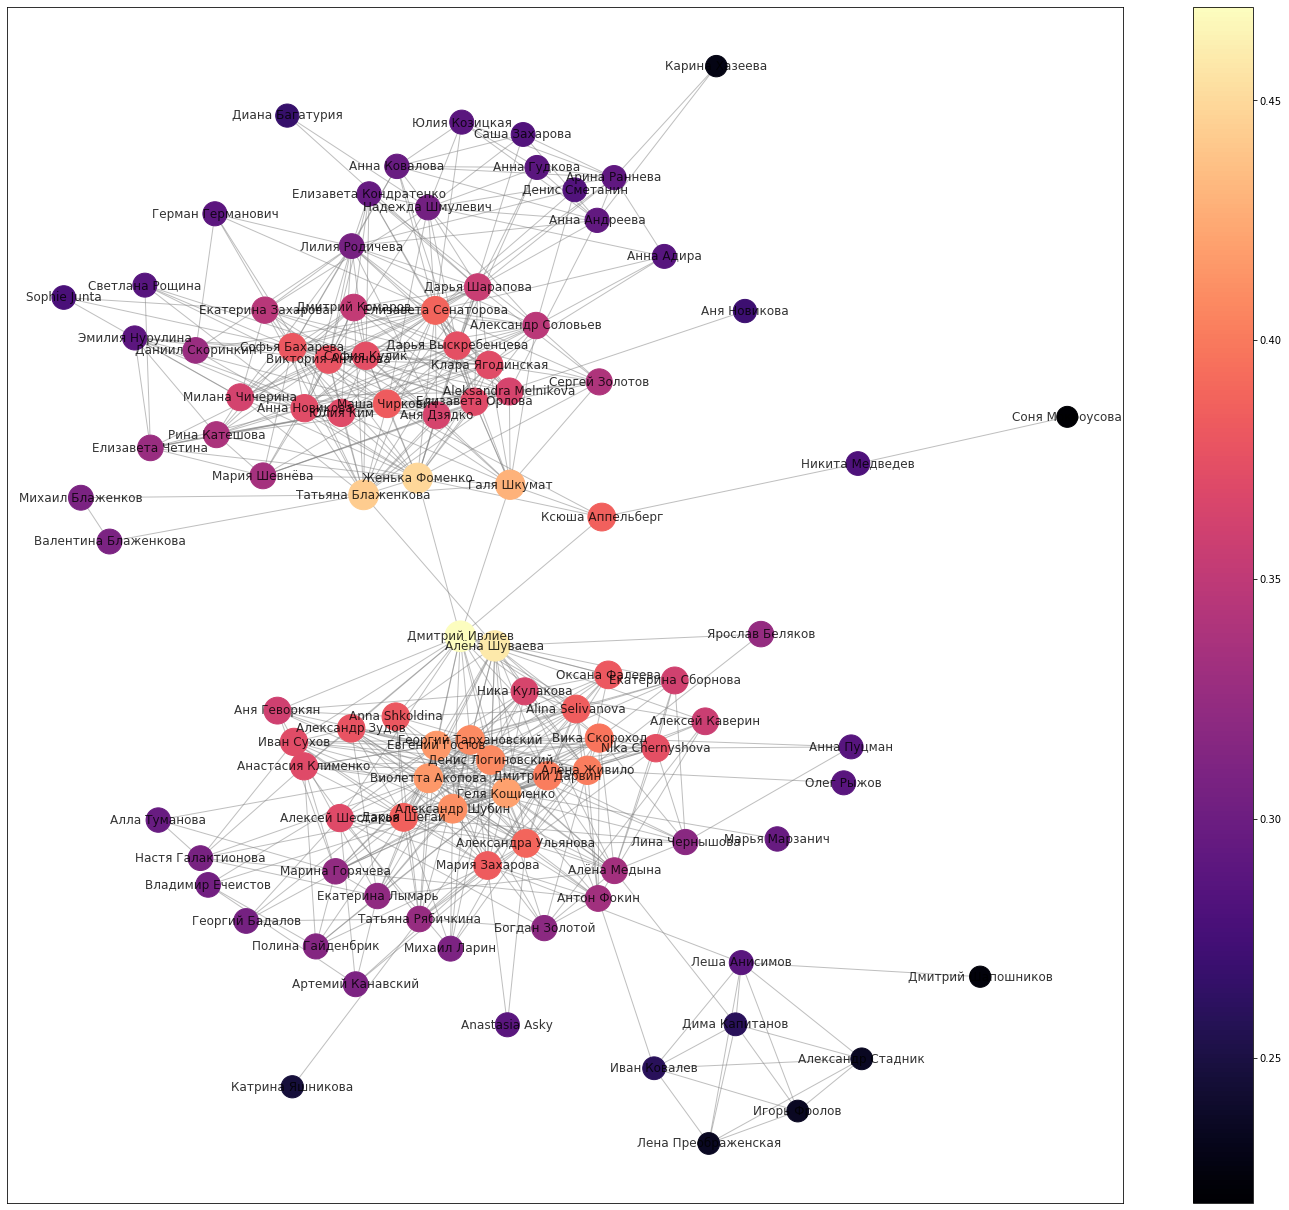

In [27]:
draw_graph_with_different_nodes(G, closeness) #closeness centrality

*Closeness centrality*. Аналогично графу, где размер и цвет узлов определён betweenness centrality, выделяются более центральные узлы.

In [28]:
draw_graph_with_different_nodes(G, eigenvector) #eigenvector centrality

*Eigenvector centrality*. Важность узла определяется по важности окружающих его соседей. Интересно, что только в одном из сообществ (*школьные друзья*) много точек с высоким показателем eigenvector centrality, так что этот граф тоже кажется недостаточно информативным.

### Сообщества.

In [29]:
comp = girvan_newman(G)
res = {i:words for i, words in enumerate(tuple(sorted(c) for c in next(comp)))}

In [30]:
modularity_scores = {}
for i in range(12):
    k = i
    comp = girvan_newman(G)
    limited = itertools.takewhile(lambda c: len(c) <= k, comp)
    for communities in limited:
        res = {i:words for i, words in enumerate(tuple(sorted(c) for c in communities))}
        modularity_scores[k] = community.modularity(G, communities)

In [31]:
{k: v for k, v in sorted(modularity_scores.items(), key=lambda item: item[1])}

{2: 0.4919426937892518,
 11: 0.5086505667707861,
 10: 0.5104275890994581,
 9: 0.5129565346960852,
 8: 0.513177282811448,
 7: 0.5140161256498273,
 6: 0.5148535888124856,
 5: 0.5157338219224953,
 3: 0.5158842065760865,
 4: 0.5165699054094326}

При 4 сообществах наиболее высокое значение modularity. Использую это значение при построении графа.

In [32]:
k = 4
comp = girvan_newman(G)
limited = itertools.takewhile(lambda c: len(c) <= k, comp)
for communities in limited:
    res = {i:words for i, words in enumerate(tuple(sorted(c) for c in communities))}

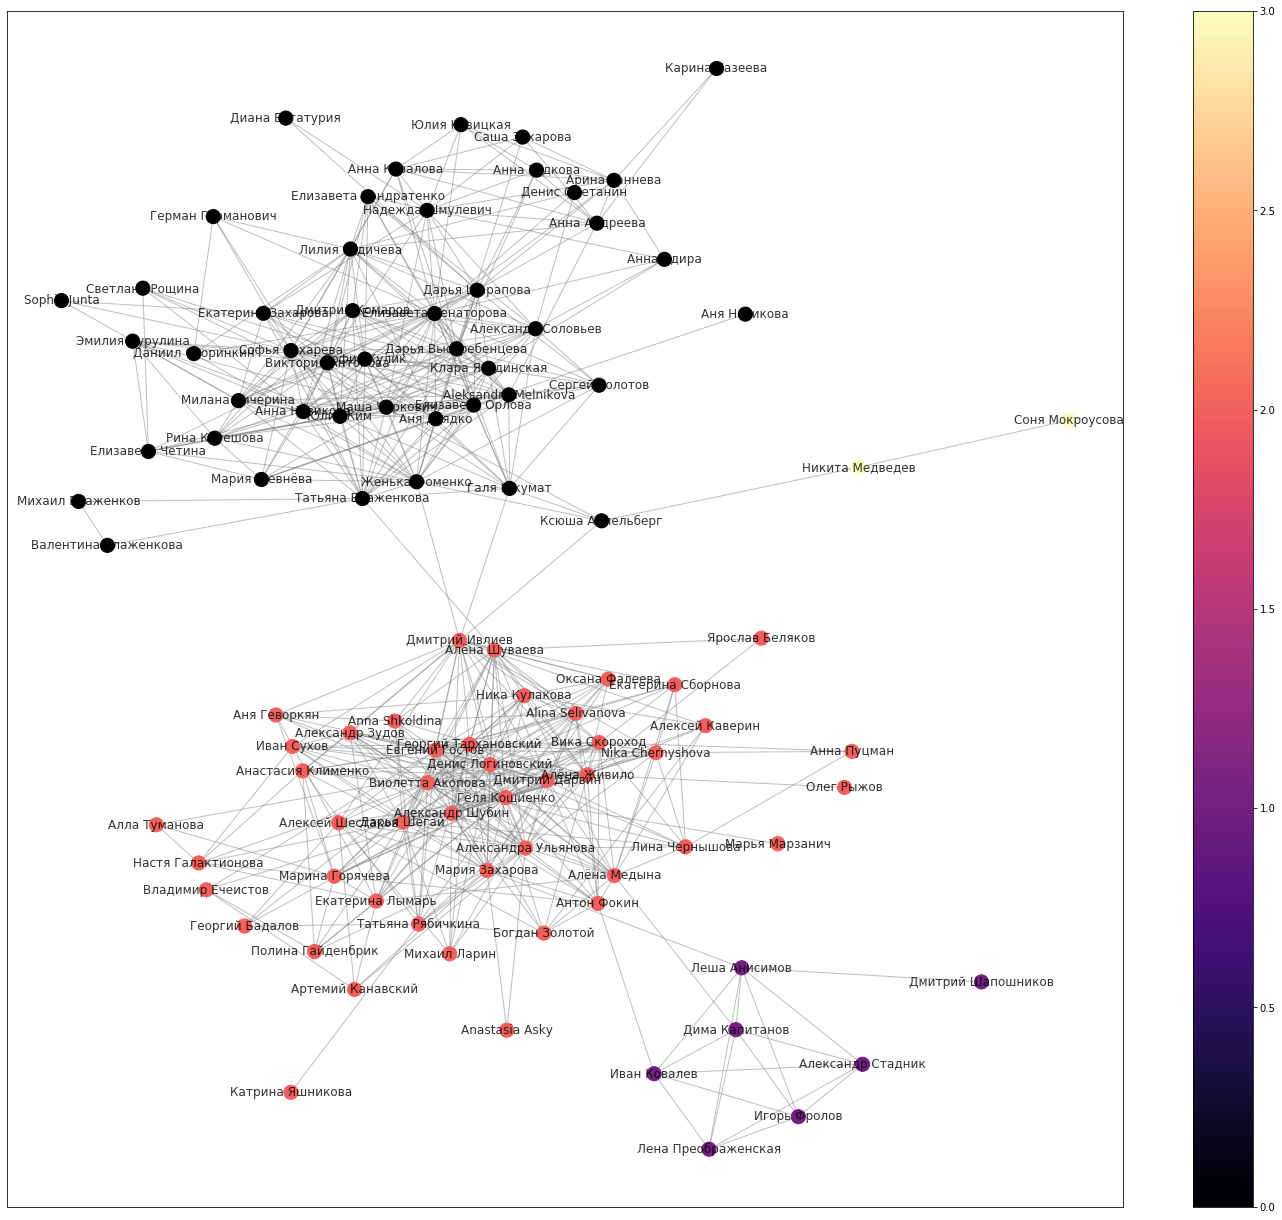

In [33]:
colour = [ ]
for v in G.nodes():
    for i, words in res.items():
        if v in words:
            colour.append(i)
plt.figure(figsize=set_figsize)

g_edges = nx.draw_networkx_edges(G, pos,
                                     edge_color = 'grey',
                                     alpha = 0.5,)
g_nodes = nx.draw_networkx_nodes(G, pos, 
                                     node_size=200,
                                     node_color=colour,
                                     cmap=plt.cm.magma,)
g_labels = nx.draw_networkx_labels(G, pos, alpha = 0.8,)
g_colors = plt.colorbar(g_nodes)

Как видно, выделилось 4 сообщества. Три, которые были заметны и ранее (мои одноклассники, однокурсники и друзья моего брата), а также 2 человека, не помню почему оказавшиеся у меня в друзьях ¯\\_(ツ)_/¯.

In [34]:
best_partition = community_louvain.best_partition(G)
modularity = community_louvain.modularity(best_partition, G)

print('Сообществ: {}'.format(max(best_partition.values())+1))
print('Модулярность: {}'.format(modularity))
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=set_figsize)
g_edges = nx.draw_networkx_edges(G, pos,
                                     edge_color = 'grey',
                                     alpha = 0.5,)
g_nodes = nx.draw_networkx_nodes(G, pos, 
                                     node_size=200,
                                     node_color=list(best_partition.values()),
                                     cmap=plt.cm.magma,)
g_labels = nx.draw_networkx_labels(G, pos, alpha = 0.8,)
g_colors = plt.colorbar(g_nodes)

Сообществ: 5
Модулярность: 0.5257240538183905


Метод Louvain дал в целом аналогичные результаты. Но всё же оказался чуть-чуть точнее: обнаружил ещё одно сообщество среди университетских знакомых.

### Сравнение сообществ

In [35]:
community_school = []
community_uni = []
#я решил использовать при сравнении сообществ чуть более точные результаты метода Louvain.
for key, value in best_partition.items():
    if value == 1:
        community_uni.append(key)
    if value == 3:
        community_school.append(key)

In [36]:
g_school = G.subgraph(community_school) #подграф со школьными друзьями
g_uni = G.subgraph(community_uni) #подграф с университетскими

In [37]:
descriptive_analysis(g_school) #школа

Анализ неориентированного графа
Компонент: 1
Вершин: 46
Рёбер: 296
Плотность: 0.28599033816425123
Диаметр графа: 4
Средняя степень вершины: 6.434782608695652
Средняя кратчайшая длина пути: 1.8599033816425121
Средний коэффициент кластеризации: 0.5639165686816002


In [38]:
descriptive_analysis(g_uni) #университет

Анализ неориентированного графа
Компонент: 1
Вершин: 36
Рёбер: 234
Плотность: 0.37142857142857144
Диаметр графа: 3
Средняя степень вершины: 6.5
Средняя кратчайшая длина пути: 1.7380952380952381
Средний коэффициент кластеризации: 0.6853179636392384


"Школьный подграф" чуть больше, чем "университетский". При этом он менее плотный, и в нём ниже средняя степень вершины. Возможно (лишь гипотеза!), это связано с тем, что за прошедшие с выпуска несколько лет многие одноклассники могли удалить менее нужные контакты из списка друзей.
"Университетский" граф достаточно близок к модели Small world, потому что у него достаточно небольшой диаметр и высокий средний кластерный коэффициент.

In [39]:
centralities_school = centralities(g_school)
centralities_uni = centralities(g_uni)

In [40]:
degree_school = list(centralities_school['degree_centrality'])
degree_uni = list(centralities_uni['degree_centrality'])

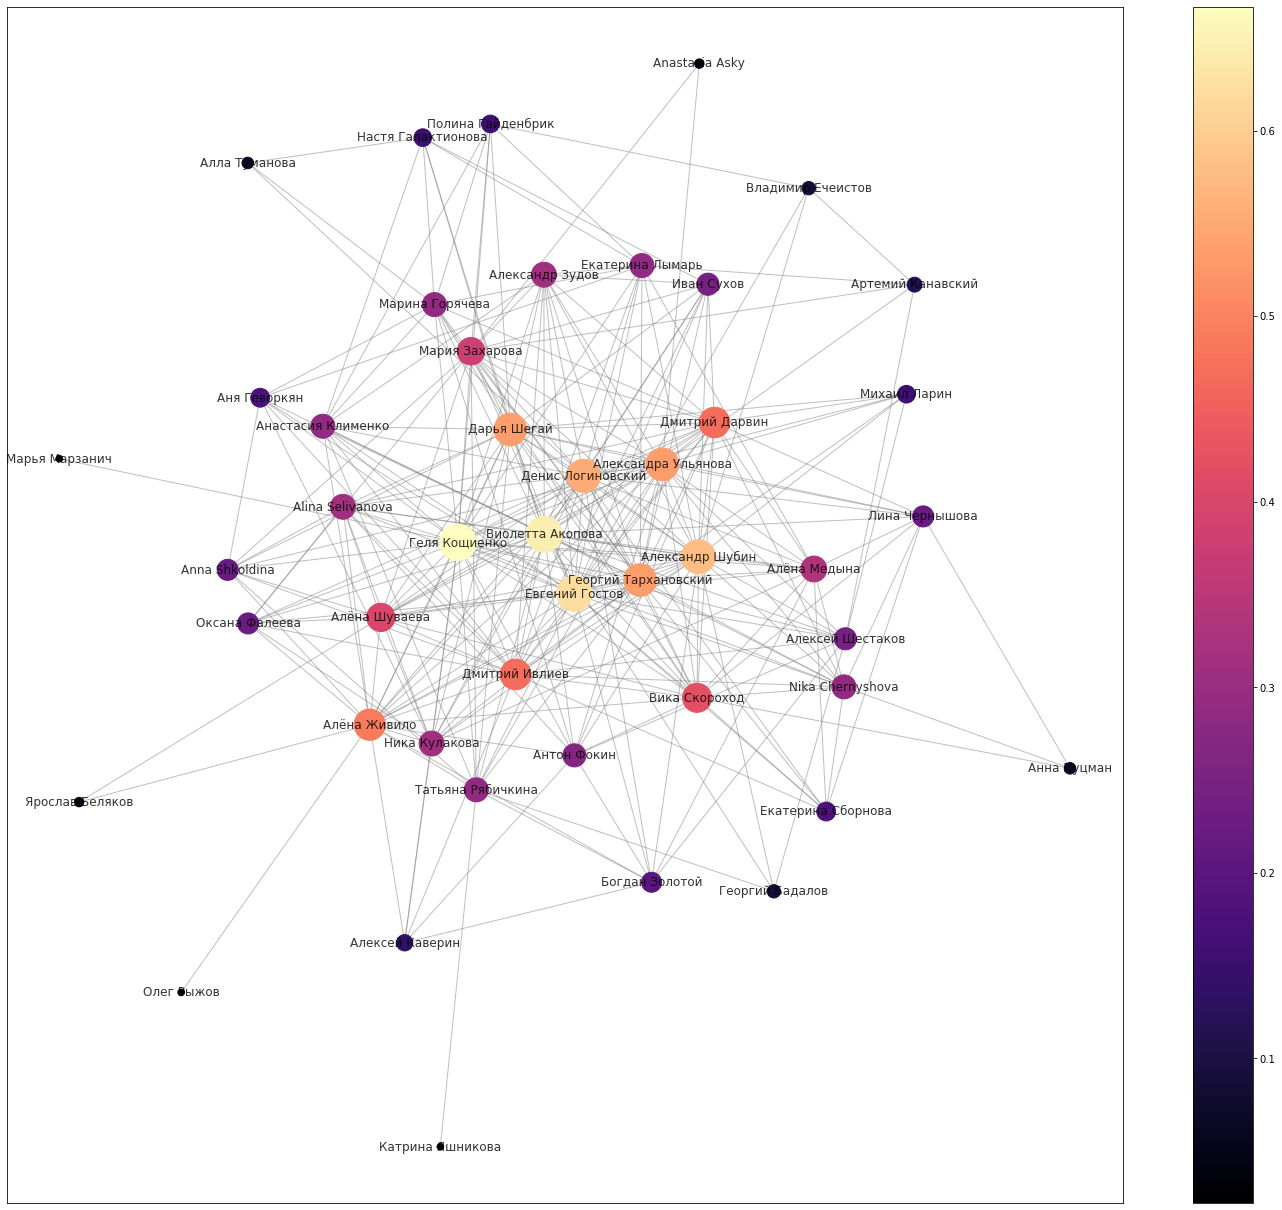

In [41]:
draw_graph_with_different_nodes(g_school, degree_school) #degree centrality, школа

In [42]:
draw_graph_with_different_nodes(g_uni, degree_uni) #degree centrality, университет

### Попытка k-core decomposition

Так можно найти ядро графа, наиболее связные компоненты внутри него.

In [43]:
k2_graph = k_core(G, k=2)
k3_graph = k_core(G, k=3)
k4_graph = k_core(G, k=4)
k5_graph = k_core(G, k=5)
k6_graph = k_core(G, k=6)
k7_graph = k_core(G, k=7)
k8_graph = k_core(G, k=8)

In [44]:
colors = ['navy', 'lightsalmon', 'seagreen', 'palevioletred', 'bisque', 'orchid', 'teal', 'crimson']

node_color = { i: 'red' for i in  G.nodes}
#print(node_color)
for i, nodes in  enumerate([k2_graph.nodes, k3_graph.nodes, k4_graph.nodes, 
                            k5_graph.nodes, k6_graph.nodes, k7_graph.nodes,
                            k8_graph.nodes
                           ]):
    print(i)
    for n in nodes: 
        node_color[n] = colors[i]
#print(node_color)

0
1
2
3
4
5
6


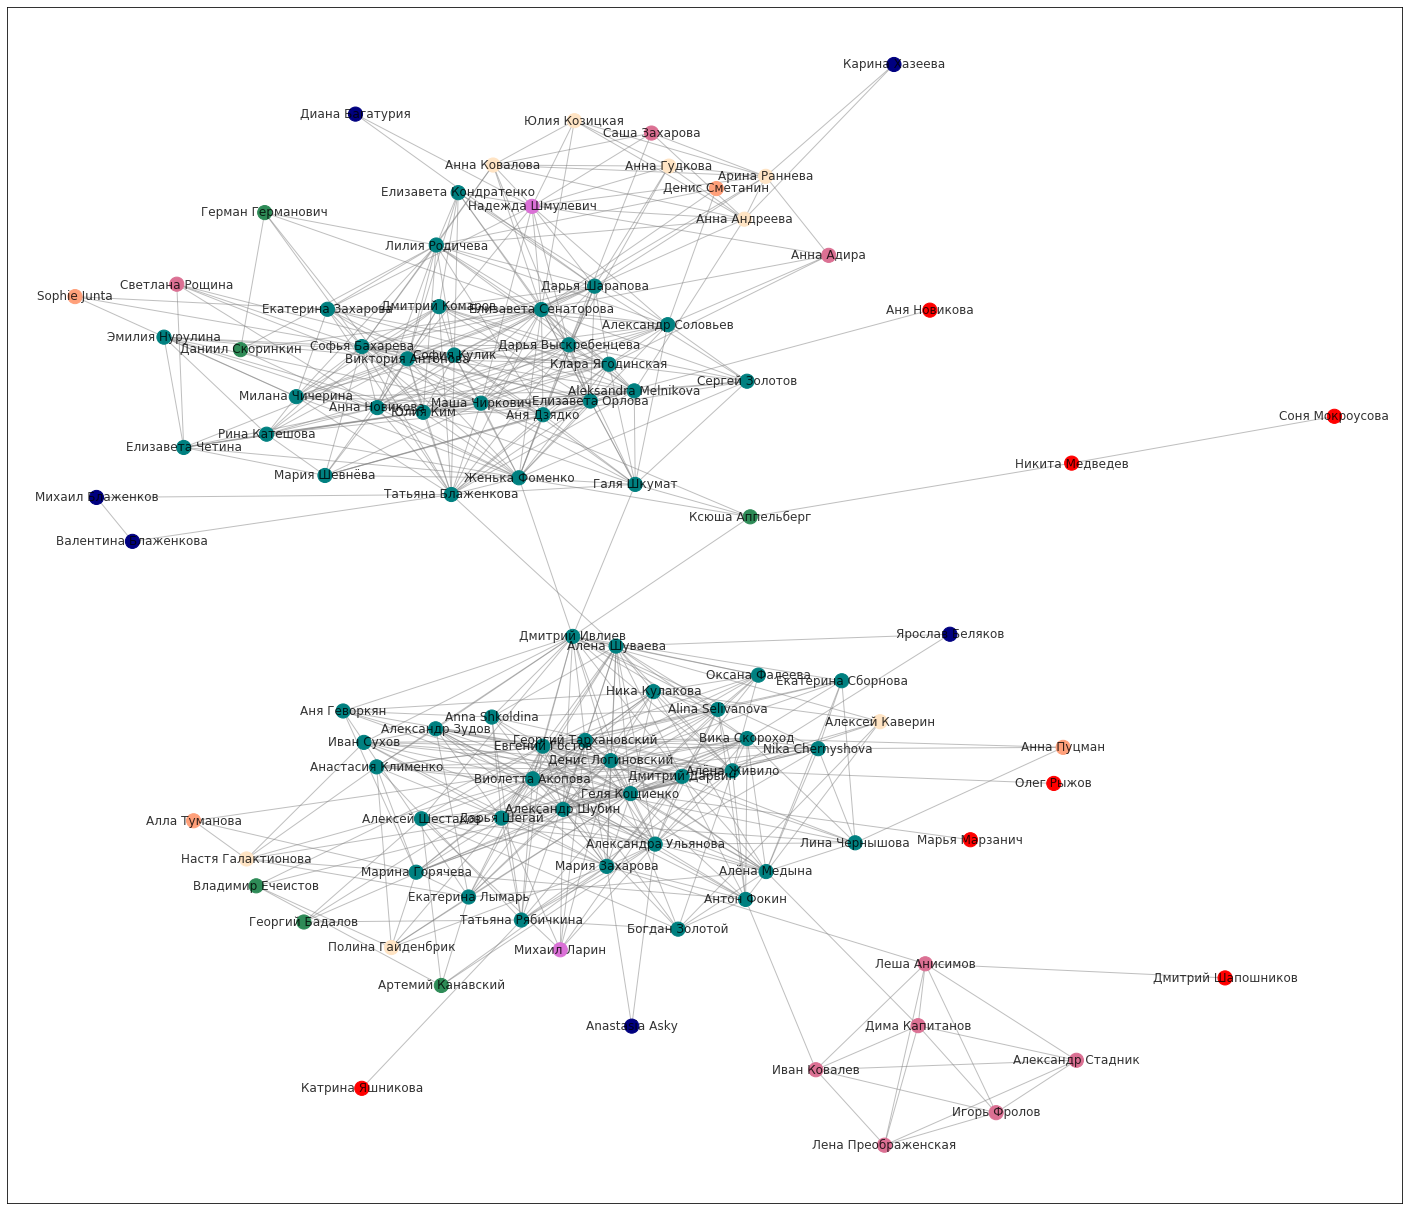

In [45]:
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=set_figsize)
g_edges = nx.draw_networkx_edges(G, pos,
                                     edge_color = 'grey',
                                     alpha = 0.5,)
g_nodes = nx.draw_networkx_nodes(G, pos, 
                                     node_size=200,
                                     node_color=node_color.values(),
                                     cmap=plt.cm.magma,)
g_labels = nx.draw_networkx_labels(G, pos, alpha = 0.8,)

In [46]:
def assort_degree_print(G): #чтобы измерять сходства связей узлов
    r = nx.degree_assortativity_coefficient(G)
    print('{}\n'.format(r))

In [47]:
print('Коэффициенты ассортативности.\n')
print('Общий граф:')
assort_degree_print(G) #в целом у графа достаточно высокий коэффициент ассортативности, значит вершины с высокой
#степенью ближе к центру, вершины с низкой степенью – дальше от него
print('k-core(2-8):')
assort_degree_print(k2_graph)
assort_degree_print(k3_graph)
assort_degree_print(k4_graph)
assort_degree_print(k5_graph)
assort_degree_print(k6_graph)
assort_degree_print(k7_graph)
assort_degree_print(k8_graph) #чем ближе к ядру графа, тем ниже коэффициент ассортативности – значит, 
#появляется больше вершин с высокой степенью, связанных с вершинами с низкой степенью

Коэффициенты ассортативности.

Общий граф:
0.04254892043811176

k-core(2-8):
0.031840619240453734

0.026002508067556503

0.023749354446508733

0.05022837992309284

-0.05753692781670843

-0.15076180450180807

-0.1402213583461121



### Визуализация

In [48]:
nx.write_gexf(G, './processed_data.gexf') 
#записываю получившийся граф в файл .gexf, чтобы нарисовать визуализацию в Gephi

#### Визуализация 1: 
![vis1](./gephi_images/example3.png)

Разреженный граф с метками. Алгоритм укладки – ForceAtlas2. Цвет узлов обозначает степень вершины.

#### Визуализация 2:
![vis2](./gephi_images/example1.png)


Граф без меток с усилением гравитации. Алгоритм укладки – ForceAtlas2. Цвет узлов обозначает степень вершины.